In [10]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
try: 
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
except:
    pass
import os,sys,warnings
warnings.filterwarnings('ignore')

# Lane Detection for assistance to the Visually Impaired 

# Model

## Canny Filter

In [11]:
import cv2 as cv
import numpy as np
# import matplotlib.pyplot as plt

def do_canny(frame):
    # Converts frame to grayscale because we only need the luminance channel for detecting edges 
    #- less computationally expensive
    gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    # Applies a 5x5 gaussian blur with deviation of 0 to frame - not mandatory since Canny will do this for us
    blur = cv.GaussianBlur(gray, (13, 13), 0)
    # Applies Canny edge detector with minVal of 50 and maxVal of 150
#     v = np.median(blur)
#     sigma = 0.33
#     #---- Apply automatic Canny edge detection using the computed median----
#     lower = int(max(0, (1.0 - sigma) * v))
#     upper = int(min(255, (1.0 + sigma) * v))
    canny = cv.Canny(blur,50,150)
    return canny



### Displaying the Application of Canny Filter

In [4]:
one = cv.imread(r"D:\III semester\Web Technology\Web-Technology\Assignment 5\india.jpg")

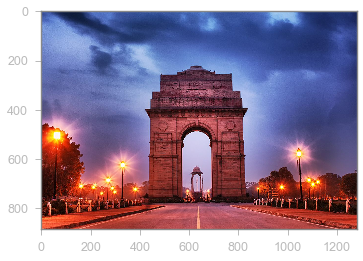

In [35]:
one = cv.cvtColor(one,cv.COLOR_BGR2RGB)
plt.imshow(one)

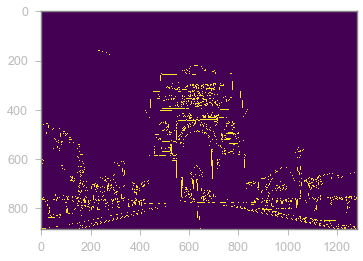

In [7]:
two = do_canny(one)
plt.imshow(two)
plt.savefig("Cannysample.jpg",dpi=200)

## Segmenting the triangular lane area

In [12]:
def do_segment(frame):
    # every image can be thought of as a matrix
    # rows , columns, channels
    # the shape attribute of the image will give you the 
    # rows(shape[0]), columns (shape[1]) and channels(shape[2])
    # channels is just the number of colors
    height = frame.shape[0]
    width = frame.shape[1]
    # making a triangular polygon with three x,y co-ordinates.
    poly = np.array([
        [(0,height),(width,height),(int(frame.shape[1]/2),int(frame.shape[0]/3))] # making a pentagonal mask for the segment.
    ])
    # create an image with zero intensity with same dimensions as frame.
    mask = np.zeros_like(frame)
    cv.fillPoly(mask,poly,255) # filling the frame's pentagon with ones
    
    # a bitwise & operation between mask and frame keeps
    # only the pentagonal area of the frame
    segment = cv.bitwise_and(frame,mask)
    
    return segment

In [80]:
?cv.fillPoly

### Displaying application of segmented canny

Text(0.5, 1.0, 'Original Image')

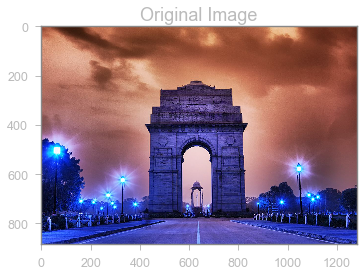

In [5]:
plt.imshow(one)
plt.title("Original Image",fontsize =18)

E:\InnerveHackathon\Detection Stages and  Examples


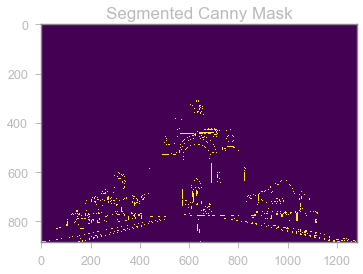

In [6]:
plt.imshow(do_segment(do_canny(one)))
plt.title("Segmented Canny Mask",fontsize=17)
%cd "E:\InnerveHackathon\Detection Stages and  Examples\"
plt.savefig("Segemented Canny Sample",dpi = 200)

In [135]:
?np.polyfit

## Hough Transform

In [13]:
def calculate_lines(frame,lines):
    # Empty arrays to store the co-ordinates of left and right lines
    left = []
    right = []
    if(lines is None):
        return (np.array([0,0,0,0]),np.array([0,0,0,0]))
    for line in lines:
        #loop through the lines found.
        x1,y1,x2,y2 = line.reshape(4)
        # fit a linear polynomial to the x and y coordinates 
        # and returns a vector of coefficients which describe 
        # the slope and the intercept.
        parameters = np.polyfit((x1,x2),(y1,y2),1)
        slope = parameters[0]
        y_intercept = parameters[1]
         # If slope is negative, the line is to the left of the lane, and otherwise, the line is to the right of the lane
        if slope < 0:
            left.append((slope, y_intercept))
        else:
            right.append((slope, y_intercept))
    # Averages out all the values for left and right into a single slope and y-intercept value for each line
    left_avg = np.average(left, axis = 0)
    right_avg = np.average(right, axis = 0)
    # Calculates the x1, y1, x2, y2 coordinates for the left and right lines
    if(left_avg!=[]):
        left_line = calculate_coordinates(frame, left_avg)
    else:
        left_line = np.array([0,0,0,0])
    if(right_avg!=[]):
        right_line = calculate_coordinates(frame, right_avg)
    else:
        right_line = np.array([0,0,0,0])
    return np.array([left_line, right_line])

def calculate_coordinates(frame, parameters):
    try:
        slope, intercept = parameters
    except:
        slope = 0.001
        intercept = 0
    # Sets initial y-coordinate as height from top down (bottom of the frame)
    y1 = np.int64(frame.shape[0])
    # Sets final y-coordinate as 150 above the bottom of the frame
    y2 = np.int64(y1 - 160)
    # Sets initial x-coordinate as (y1 - b) / m since y1 = mx1 + b
    x1 = np.int64( (y1-intercept) / slope)
    # Sets final x-coordinate as (y2 - b) / m since y2 = mx2 + b
    x2 = np.int64((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

def visualize_lines(frame, lines):
    # Creates an image filled with zero intensities with the same dimensions as the frame
    lines_visualize = np.zeros_like(frame)
    # Checks if any lines are detected
    if lines is None:
        return lines_visualize
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            # Draws lines between two coordinates with green color and 5 thickness
            try:
                cv.line(lines_visualize, (x1, y1), (x2, y2), (0, 255, 0), 5)
            except:
                pass
    return lines_visualize


In [8]:
 # cv.HoughLinesP(frame, distance resolution of accumulator 
# in pixels (larger = less precision), angle resolution of accumulator in radians (larger = less precision),
# threshold of minimum number of intersections, empty placeholder array, minimum length of line in pixels, maximum distance in pixels between disconnected lines)
# hough = cv.HoughLinesP(segment, 2, np.pi / 180, 100, np.array([]), minLineLength = 100, maxLineGap = 50)

# Reading the video input

In [14]:
%cd "E:\InnerveHackathon\"


E:\InnerveHackathon


In [15]:
def rescale_frame(frame,percent=75):
    width = int(frame.shape[1] * percent / 100)
    height = int(frame.shape[0] * percent / 100)
    dim = (width,height)
    return cv.resize(frame,dim,interpolation = cv.INTER_AREA)

In [16]:
cap = cv.VideoCapture(r"pathvalild.mp4")
while (cap.isOpened()):
    # ret = a boolean return value from getting the frame,
    # frame = teh current frame being projected in video
    
    ret, frame = cap.read()
    try:
        frame = rescale_frame(frame,percent = 57)
    except:
        break
    canny = do_canny(frame)
    # First, visualize the frame to figure out the three coordinates defining the triangular mask
    #plt.imshow(frame)
    cv.imshow("Original",frame)
    #cv.namedWindow("Original",cv.WINDOW_NORMAL)
    #cv.resizeWindow("Original",500,300)
    cv.imshow("Canny filtered",canny)
    #cv.windowSize("Original",400,400)
    # making the segment constrained so that detection is
    # confined.
    segment = do_segment(canny)
    hough = cv.HoughLinesP(segment, 2, np.pi / 180, 100, np.array([]), minLineLength = 80, maxLineGap = 50)
    cv.imshow("Segmented canny",segment)
    # frames read at 10 Millsecond intervals.
    # Averages multiple detected lines from hough into one line for left border of lane and one line for right border of lane
    lines = calculate_lines(frame, hough)
    # Visualizes the lines
    lines_visualize = visualize_lines(frame, lines)
    #cv.imshow("hough", lines_visualize)
    # Overlays lines on frame by taking their weighted sums and adding an arbitrary scalar value of 1 as the gamma argument
    output = cv.addWeighted(frame, 0.9, lines_visualize, 1, 1)
    # Opens a new window and displays the output frame
    cv.imshow("output", output)
    cv.VideoWriter()
    # When user presses 'q' the while loop is broken
    if cv.waitKey(15) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()
# releasing all the resources.